CartPole Skating

The problem we have been solving in the previous lesson might seem like a toy problem, not really applicable for real life scenarios. This is not the case, because many real world problems also share this scenario - including playing Chess or Go. They are similar, because we also have a board with given rules and a discrete state. https://white-water-09ec41f0f.azurestaticapps.net/

Introduction

In this lesson we will apply the same principles of Q-Learning to a problem with continuous state, i.e. a state that is given by one or more real numbers. We will deal with the following problem:

Problem: If Peter wants to escape from the wolf, he needs to be able to move faster. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

We will use a simplified version of balancing known as a CartPole problem. In the cartpole world, we have a horizontal slider that can move left or right, and the goal is to balance a vertical pole on top of the slider.

Prerequisites

In this lesson, we will be using a library called OpenAI Gym to simulate different environments. You can run this lesson's code locally (eg. from Visual Studio Code), in which case the simulation will open in a new window. When running the code online, you may need to make some tweaks to the code, as described here.

OpenAI Gym

In the previous lesson, the rules of the game and the state were given by the Board class which we defined ourselves. Here we will use a special simulation environment, which will simulate the physics behind the balancing pole. One of the most popular simulation environments for training reinforcement learning algorithms is called a Gym, which is maintained by OpenAI. By using this gym we can create difference environments from a cartpole simulation to Atari games.

First, let's install the gym and import required libraries (code block 1):

In [22]:
import sys
#!{sys.executable} -m pip install gymnasium[classic-control]


import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random

Exercise - initialize a cartpole environment

to work with a cartpole balancing problem, we need to initialize corresponding environment. Each environment is associated with an:

    Observation space that defines the structure of information that we receive from the environment. For cartpole problem, we receive position of the pole, velocity and some other values.

    Action space that defines possible actions. In our case the action space is discrete, and consists of two actions - left and right. (code block 2)


To initialize, type the following code:

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
1


To see how the environment works, let's run a short simulation for 100 steps. At each step, we provide one of the actions to be taken - in this simulation we just randomly select an action from action_space.

In [3]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

c:\Users\user\miniconda3\envs\Arewads\lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
c:\Users\user\miniconda3\envs\Arewads\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


During simulation, we need to get observations in order to decide how to act. In fact, the step function returns current observations, a reward function, and the done flag that indicates whether it makes sense to continue the simulation or not: (code block 4)

In [4]:
env.reset()
info = None
done = False
while not done:
   env.render()
   obs, rew, done, info,_ = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[-0.00441391 -0.18106255  0.04939996  0.28994638] -> 1.0
[-0.00803516  0.01332146  0.05519888  0.01324376] -> 1.0
[-0.00776873  0.20761012  0.05546376 -0.26152512] -> 1.0
[-0.00361653  0.01174211  0.05023326  0.04812309] -> 1.0
[-0.00338168 -0.18406281  0.05119572  0.35622236] -> 1.0
[-0.00706294  0.01029529  0.05832016  0.08011214] -> 1.0
[-0.00685703 -0.1856121   0.05992241  0.39061   ] -> 1.0
[-0.01056928  0.00861048  0.06773461  0.11740569] -> 1.0
[-0.01039707 -0.18741329  0.07008272  0.43066585] -> 1.0
[-0.01414533 -0.38345402  0.07869604  0.74459255] -> 1.0
[-0.02181441 -0.57956874  0.09358789  1.060967  ] -> 1.0
[-0.03340579 -0.775797    0.11480723  1.381496  ] -> 1.0
[-0.04892173 -0.97214925  0.14243715  1.7077646 ] -> 1.0
[-0.06836471 -1.1685928   0.17659244  2.041181  ] -> 1.0
[-0.09173657 -0.9756727   0.21741606  1.80795   ] -> 1.0


The observation vector that is returned at each step of the simulation contains the following values:

    Position of cart

    Velocity of cart

    Angle of pole
    
    Rotation rate of pole


Get min and max value of those numbers: (code block 5)

In [5]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


State discretization

In Q-Learning, we need to build Q-Table that defines what to do at each state. To be able to do this, we need state to be discreet, more precisely, it should contain finite number of discrete values. Thus, we need somehow to discretize our observations, mapping them to a finite set of states.

There are a few ways we can do this:

Divide into bins. If we know the interval of a certain value, we can divide this interval into a number of bins, and then replace the value by the bin number that it belongs to. This can be done using the numpy digitize method. In this case, we will precisely know the state size, because it will depend on the number of bins we select for digitalization.

Here is the function that will take the observation from our model and produce a tuple of 4 integer values: (code block 6)

In [6]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

Let's also explore another discretization method using bins: (code block 7)

In [7]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Let's now run a short simulation and observe those discrete environment values. Feel free to try both discretize and discretize_bins and see if there is a difference.

discretize_bins returns the bin number, which is 0-based. Thus for values of input variable around 0 it returns the number from the middle of the interval (10). In discretize, we did not care about the range of output values, allowing them to be negative, thus the state values are not shifted, and 0 corresponds to 0. (code block 8)

In [8]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info,_ = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, 1, -3)
(0, 1, 1, -6)
(0, 0, 0, -3)
(0, 0, 0, 0)
(0, 0, 0, 2)
(0, 0, 0, 0)
(0, 0, 0, 2)
(0, 0, 0, 0)
(0, 0, 0, -3)
(0, 0, 0, 0)
(0, 0, 0, 2)
(0, 0, 0, 0)
(0, 0, 0, -3)
(0, 0, 0, 0)
(0, 0, 0, -3)
(0, 0, -1, 0)
(0, 0, -1, 2)
(0, -1, 0, 5)
(0, -2, 0, 8)
(0, -3, 1, 11)
(0, -2, 4, 8)
(0, -3, 5, 11)
(0, -2, 8, 8)
(0, -3, 9, 11)
(0, -2, 12, 9)
(0, -3, 13, 12)
(0, -2, 16, 10)
(0, -1, 18, 7)
(0, -1, 20, 5)
(0, 0, 21, 3)


C:\Users\user\AppData\Local\Temp\ipykernel_8508\2541155765.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))


The Q-Table structure

In our previous lesson, the state was a simple pair of numbers from 0 to 8, and thus it was convenient to represent Q-Table by a numpy tensor with a shape of 8x8x2. If we use bins discretization, the size of our state vector is also known, so we can use the same approach and represent state by an array of shape 20x20x10x10x2 (here 2 is the dimension of action space, and first dimensions correspond to the number of bins we have selected to use for each of the parameters in observation space).

However, sometimes precise dimensions of the observation space are not known. In case of the discretize function, we may never be sure that our state stays within certain limits, because some of the original values are not bound. Thus, we will use a slightly different approach and represent Q-Table by a dictionary.

Use the pair (state,action) as the dictionary key, and the value would correspond to Q-Table entry value. (code block 9)

In [9]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

Here we also define a function qvalues(), which returns a list of Q-Table values for a given state that corresponds to all possible actions. If the entry is not present in the Q-Table, we will return 0 as the default.

Now we are ready to teach Peter to balance!

First, let's set some hyperparameters: (code block 10)

In [10]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

Here, alpha is the learning rate that defines to which extent we should adjust the current values of Q-Table at each step. In the previous lesson we started with 1, and then decreased alpha to lower values during training. In this example we will keep it constant just for simplicity, and you can experiment with adjusting alpha values later.

gamma is the discount factor that shows to which extent we should prioritize future reward over current reward.

epsilon is the exploration/exploitation factor that determines whether we should prefer exploration to exploitation or vice versa. In our algorithm, we will in epsilon percent of the cases select the next action according to Q-Table values, and in the remaining number of cases we will execute a random action. This will allow us to explore areas of the search space that we have never seen before.

Improve the algorithm

We can also make two improvements to our algorithm from the previous lesson:

    Calculate average cumulative reward, over a number of simulations. We will print the progress each 5000 iterations, and we will average out our cumulative reward over that period of time. It means that if we get more than 195 point - we can consider the problem solved, with even higher quality than required.

    Calculate maximum average cumulative result, Qmax, and we will store the Q-Table corresponding to that result. When you run the training you will notice that sometimes the average cumulative result starts to drop, and we want to keep the values of Q-Table that correspond to the best model observed during training.

    

Collect all cumulative rewards at each simulation at rewards vector for further plotting. (code block 11)

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [12]:
Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(5000):
    observation, info = env.reset()
    terminated = False
    truncated = False
    cum_reward=0
    
    # == do the simulation ==
    while not terminated and not truncated:
        s = discretize(observation)
        if random.random()<epsilon:
        # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
        # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        observation, reward, terminated, truncated, info = env.step(a)
        cum_reward+=reward
        ns = discretize(observation)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (reward + gamma * max(qvalues(ns)))
    
            
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%100==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

C:\Users\user\AppData\Local\Temp\ipykernel_8508\2541155765.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))


0: 14.0, alpha=0.3, epsilon=0.9
100: 23.12, alpha=0.3, epsilon=0.9
200: 29.13, alpha=0.3, epsilon=0.9
300: 36.4, alpha=0.3, epsilon=0.9
400: 36.45, alpha=0.3, epsilon=0.9
500: 37.65, alpha=0.3, epsilon=0.9
600: 38.0, alpha=0.3, epsilon=0.9
700: 45.68, alpha=0.3, epsilon=0.9
800: 49.03, alpha=0.3, epsilon=0.9
900: 50.02, alpha=0.3, epsilon=0.9
1000: 45.81, alpha=0.3, epsilon=0.9
1100: 48.29, alpha=0.3, epsilon=0.9
1200: 53.81, alpha=0.3, epsilon=0.9
1300: 53.74, alpha=0.3, epsilon=0.9
1400: 53.6, alpha=0.3, epsilon=0.9
1500: 50.48, alpha=0.3, epsilon=0.9
1600: 50.02, alpha=0.3, epsilon=0.9
1700: 54.96, alpha=0.3, epsilon=0.9
1800: 69.92, alpha=0.3, epsilon=0.9
1900: 71.31, alpha=0.3, epsilon=0.9
2000: 82.28, alpha=0.3, epsilon=0.9
2100: 77.14, alpha=0.3, epsilon=0.9
2200: 97.25, alpha=0.3, epsilon=0.9
2300: 82.91, alpha=0.3, epsilon=0.9
2400: 86.83, alpha=0.3, epsilon=0.9
2500: 99.16, alpha=0.3, epsilon=0.9
2600: 83.94, alpha=0.3, epsilon=0.9
2700: 93.24, alpha=0.3, epsilon=0.9
2800: 73

Plotting Training Progress

During training, we have collected the cumulative reward value at each of the iterations into rewards vector. Here is how it looks when we plot it against the iteration number:

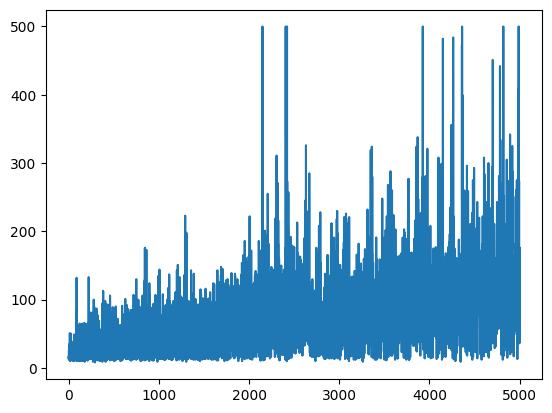

In [13]:
plt.plot(rewards)

From this graph, it is not possible to tell anything, because due to the nature of stochastic training process the length of training sessions varies greatly. To make more sense of this graph, we can calculate the running average over a series of experiments, let's say 100. This can be done conveniently using np.convolve: (code block 12)

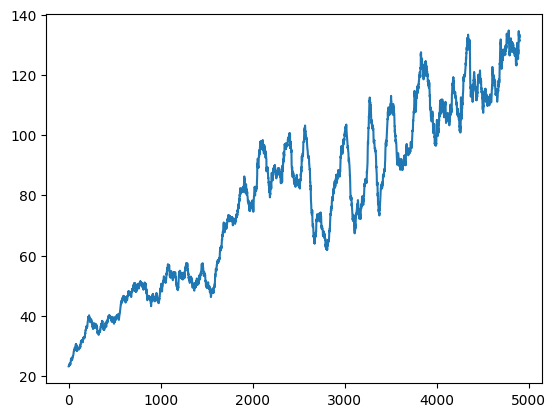

In [14]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

Varying hyperparameters

To make learning more stable, it makes sense to adjust some of our hyperparameters during training. In particular:

    For learning rate, alpha, we may start with values close to 1, and then keep decreasing the parameter. With time, we will be getting good probability values in the Q-Table, and thus we should be adjusting them slightly, and not overwriting completely with new values.

    Increase epsilon. We may want to increase the epsilon slowly, in order to explore less and exploit more. It probably makes sense to start with lower value of epsilon, and move up to almost 1.


Seeing the result in action

It would be interesting to actually see how the trained model behaves. Let's run the simulation and follow the same action selection strategy as during training, sampling according to the probability distribution in Q-Table: (code block 13)

In [24]:
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    s = discretize(observation)
    v = probs(np.array(qvalues(s)))
    a = random.choices(actions,weights=v)[0]
    observation, reward, terminated, truncated, info = env.step(a)
    
env.close()

C:\Users\user\AppData\Local\Temp\ipykernel_8508\2541155765.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))


Saving result to an animated GIF

In [19]:
from PIL import Image
env = gym.make("CartPole-v1", render_mode = "rgb_array")
observation, info = env.reset()
i=0
ims = []
terminated = False
truncated = False
while not terminated and not truncated:
   s = discretize(observation)
   img= env.render()
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   observation, reward, terminated, truncated, info = env.step(a)
   i+=1
   
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

C:\Users\user\AppData\Local\Temp\ipykernel_8508\2541155765.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))


36
